In [3]:
from __future__ import print_function
import mxnet as mx
import mxnet.ndarray as nd
from mxnet import autograd
import numpy as np

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [5]:
ctx = mx.cpu() 

In [6]:
mnist = mx.test_utils.get_mnist()
num_examples = 1000
batch_size = 64
train_data = mx.gluon.data.DataLoader(
    mx.gluon.data.ArrayDataset(mnist["train_data"][:num_examples],
                               mnist["train_label"][:num_examples].astype(np.float32)),
                               batch_size, shuffle=True)
test_data = mx.gluon.data.DataLoader(
    mx.gluon.data.ArrayDataset(mnist["test_data"][:num_examples],
                               mnist["test_label"][:num_examples].astype(np.float32)),
                               batch_size, shuffle=False)

In [7]:
# weight
W = nd.random_normal(shape=(784,10))
# bias
b = nd.random_normal(shape=10)

params = [W, b]

for param in params:
    param.attach_grad()

def net(X):
    y_linear = nd.dot(X, W) + b
    yhat = nd.softmax(y_linear, axis=1)
    return yhat

In [8]:
# cross entropy 
def cross_entropy(yhat, y):
    return - nd.sum(y * nd.log(yhat), axis=0, exclude=True)

# stochastic gradient descent 
def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

In [9]:
def evaluate_accuracy(data_iterator, net):
    numerator = 0.
    denominator = 0.
    loss_avg = 0.
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        label_one_hot = nd.one_hot(label, 10)
        output = net(data)
        loss = cross_entropy(output, label_one_hot)
        predictions = nd.argmax(output, axis=1)
        numerator += nd.sum(predictions == label)
        denominator += data.shape[0]
        loss_avg = loss_avg*i/(i+1) + nd.mean(loss).asscalar()/(i+1)
    return (numerator / denominator).asscalar(), loss_avg

In [10]:
def plot_learningcurves(loss_tr,loss_ts, acc_tr,acc_ts):
    xs = list(range(len(loss_tr)))

    f = plt.figure(figsize=(12,6))
    fg1 = f.add_subplot(121)
    fg2 = f.add_subplot(122)

    fg1.set_xlabel('epoch',fontsize=14)
    fg1.set_title('Comparing loss functions')
    fg1.semilogy(xs, loss_tr)
    fg1.semilogy(xs, loss_ts)
    fg1.grid(True,which="both")

    fg1.legend(['training loss', 'testing loss'],fontsize=14)

    fg2.set_title('Comparing accuracy')
    fg1.set_xlabel('epoch',fontsize=14)
    fg2.plot(xs, acc_tr)
    fg2.plot(xs, acc_ts)
    fg2.grid(True,which="both")
    fg2.legend(['training accuracy', 'testing accuracy'],fontsize=14)

Completed epoch 100. Train Loss: 0.5520768174901604, Test Loss 1.4114970564842224, Train_acc 0.862, Test_acc 0.725
Completed epoch 200. Train Loss: 0.24176504462957377, Test Loss 1.2982083074748516, Train_acc 0.94, Test_acc 0.735
Completed epoch 300. Train Loss: 0.1347866663709283, Test Loss 1.2760326862335207, Train_acc 0.971, Test_acc 0.748
Completed epoch 400. Train Loss: 0.08687989809550344, Test Loss 1.2594414539635184, Train_acc 0.989, Test_acc 0.758
Completed epoch 500. Train Loss: 0.06208236073143781, Test Loss 1.2473130896687508, Train_acc 0.996, Test_acc 0.765
Completed epoch 600. Train Loss: 0.04344097583089023, Test Loss 1.2392210680991411, Train_acc 0.998, Test_acc 0.762
Completed epoch 700. Train Loss: 0.03266329516191036, Test Loss 1.2348026130348446, Train_acc 0.999, Test_acc 0.764
Completed epoch 800. Train Loss: 0.026988236815668646, Test Loss 1.22999001853168, Train_acc 1.0, Test_acc 0.768
Completed epoch 900. Train Loss: 0.022807289729826145, Test Loss 1.22652034088

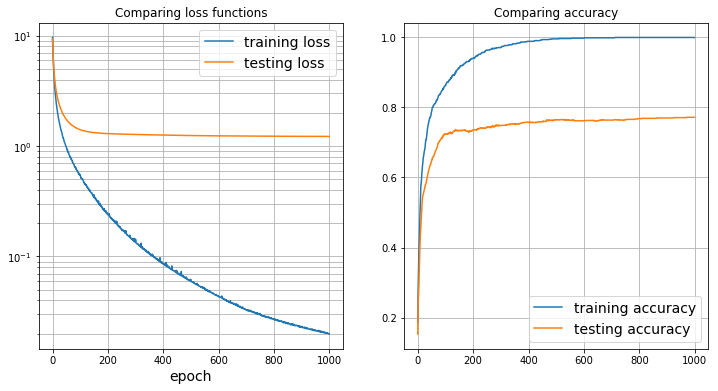

In [11]:
epochs = 1000
moving_loss = 0.
niter=0

loss_seq_train = []
loss_seq_test = []
acc_seq_train = []
acc_seq_test = []


for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        label_one_hot = nd.one_hot(label, 10)
        with autograd.record():
            output = net(data)
            loss = cross_entropy(output, label_one_hot)
        loss.backward()
        SGD(params, .001)

        ##########################
        #  Keep a moving average of the losses
        ##########################
        niter +=1
        moving_loss = .99 * moving_loss + .01 * nd.mean(loss).asscalar()
        est_loss = moving_loss/(1-0.99**niter)

    test_accuracy, test_loss = evaluate_accuracy(test_data, net)
    train_accuracy, train_loss = evaluate_accuracy(train_data, net)

    # save them for later
    loss_seq_train.append(train_loss)
    loss_seq_test.append(test_loss)
    acc_seq_train.append(train_accuracy)
    acc_seq_test.append(test_accuracy)


    if e % 100 == 99:
        print("Completed epoch %s. Train Loss: %s, Test Loss %s, Train_acc %s, Test_acc %s" %
              (e+1, train_loss, test_loss, train_accuracy, test_accuracy))


## Plotting the learning curves
plot_learningcurves(loss_seq_train,loss_seq_test,acc_seq_train,acc_seq_test)

## Regularisation

In [12]:
# penalizes the coefficients
def l2_penalty(params):
    penalty = nd.zeros(shape=1)
    for param in params:
        penalty = penalty + nd.sum(param ** 2)
    return penalty

In [13]:
# reinitialise the parameters

for param in params:
    param[:] = nd.random_normal(shape=param.shape)
    

Completed epoch 100. Train Loss: 0.3880512220785022, Test Loss 1.1569839268922808, Train_acc 0.895, Test_acc 0.729
Completed epoch 200. Train Loss: 0.1895651165395975, Test Loss 0.8122744262218476, Train_acc 0.964, Test_acc 0.769
Completed epoch 300. Train Loss: 0.14049979485571384, Test Loss 0.6654983963817357, Train_acc 0.98, Test_acc 0.799
Completed epoch 400. Train Loss: 0.12929950514808297, Test Loss 0.5874925404787064, Train_acc 0.987, Test_acc 0.809
Completed epoch 500. Train Loss: 0.1285109096206724, Test Loss 0.5451210401952267, Train_acc 0.991, Test_acc 0.815
Completed epoch 600. Train Loss: 0.12788205407559872, Test Loss 0.5236461441963911, Train_acc 0.992, Test_acc 0.826
Completed epoch 700. Train Loss: 0.12691218499094248, Test Loss 0.5120700653642416, Train_acc 0.992, Test_acc 0.832
Completed epoch 800. Train Loss: 0.12915155570954084, Test Loss 0.506969029083848, Train_acc 0.992, Test_acc 0.834
Completed epoch 900. Train Loss: 0.12824299652129412, Test Loss 0.50313211791

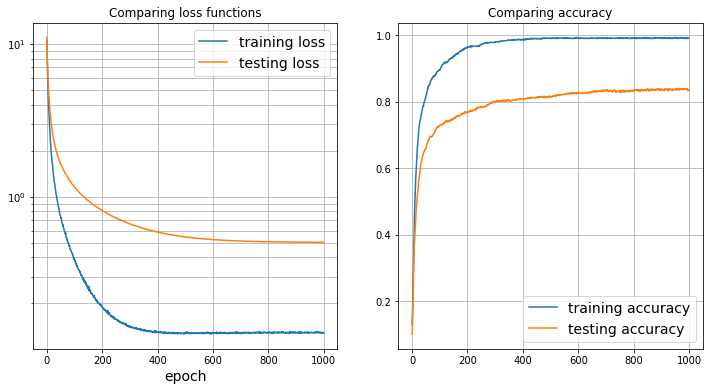

In [14]:
epochs = 1000
moving_loss = 0.
l2_strength = .1
niter=0

loss_seq_train = []
loss_seq_test = []
acc_seq_train = []
acc_seq_test = []


for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        label_one_hot = nd.one_hot(label, 10)
        with autograd.record():
            output = net(data)
            loss = nd.sum(cross_entropy(output, label_one_hot)) + l2_strength * l2_penalty(params)
        loss.backward()
        SGD(params, .001)

        ##########################
        #  Keep a moving average of the losses
        ##########################
        niter +=1
        moving_loss = .99 * moving_loss + .01 * nd.mean(loss).asscalar()
        est_loss = moving_loss/(1-0.99**niter)


    test_accuracy, test_loss = evaluate_accuracy(test_data, net)
    train_accuracy, train_loss = evaluate_accuracy(train_data, net)

    # save them for later
    loss_seq_train.append(train_loss)
    loss_seq_test.append(test_loss)
    acc_seq_train.append(train_accuracy)
    acc_seq_test.append(test_accuracy)

    if e % 100 == 99:
        print("Completed epoch %s. Train Loss: %s, Test Loss %s, Train_acc %s, Test_acc %s" %
              (e+1, train_loss, test_loss, train_accuracy, test_accuracy))


## Plotting the learning curves
plot_learningcurves(loss_seq_train,loss_seq_test,acc_seq_train,acc_seq_test)